# Using TensorFlow with Jetscape Benchmarck Dataset
**About the JETSCAPE Eloss Classification dataset**.   
Jetscape Eloss Classification is the equivalent *Hello World* of jet image analysis.
It consists of 4 categories, MATTER-VACCUUM/MATTER-MEDIUM/MATTER+LBT/MATTER+MARTINI, in 32x32 pixel squares.  
Each gray-scale pixel contains an integer 0-255 to indicate darkness, with 0 white and 255 black.  
There are about 180,000 training records, and about 20,000 test records.  
In other words, the images of numbers have already been transformed into arrays of ints to make them easier to use for ML projects. You can find more info on the jetscape [here](https://jetscape.org/). You can also download it from [here](#).


## Part 0: Prerequisites:

We recommend that you run this this notebook in the cloud on Google Colab (see link with icon at the top) if you're not already doing so. It's the simplest way to get started. You can also [install TensorFlow locally](https://www.tensorflow.org/install/).

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys
import time

# Images, plots, display, and visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import cv2
import IPython
from six.moves import urllib

print(tf.__version__)
sys.version_info
!python --version

2.8.0
Python 3.7.12


## 1. Load Data into a Numpy Array  
I downloaded the data file onto my desktop and loaded it locally.  
You can also load it directly from the cloud as follows:  
```mnist = tf.keras.datasets.mnist  
(x_train, y_train), (x_test, y_test) = jetscapeMl.load_data()  
```  
**After the load:**   
x_train contains 180k arrays of 32x32.  
The y_train vector contains the corresponding labels for these.  
x_test contains 20k arrays of 32x32.  
The y_test vector contains the corresponding labels for these.

**Building Randomized Dataset**
Before having the simulation data, researcher tried to implmenet a psudo random data to create the architecture for the project. I thought it could be useful for further usages.

In [ ]:
def dataset_y_builder(y_size,y_class_label_items):
    class_size=int(y_size/len(y_class_label_items))
    y=[]
    for class_label_item in y_class_label_items:
        y = np.append (y, [class_label_item]*class_size)
    return y

def dataset_x_builder_randomized(x_size,frame_size):
    x=np.arange(x_size*dataset_frame_size*dataset_frame_size).reshape((x_size,frame_size,frame_size))
    return x

dataset_frame_size=32
#train_size=600
#test_size=100
train_size=1600
test_size=400

y_class_label_items=['MVAC','MMED','MLBT','MMAR']
y_train=dataset_y_builder(train_size,y_class_label_items)
y_test=dataset_y_builder(test_size,y_class_label_items)


x_train=dataset_x_builder_randomized(train_size,dataset_frame_size)
x_test=dataset_x_builder_randomized(test_size,dataset_frame_size)

print(type(x_train), x_train.size, x_train.shape)
print(type(y_train), y_train.size, y_train.shape)
print(type(x_test), x_test.size, x_test.shape)
print(type(y_test), y_test.size, y_test.shape)

<class 'numpy.ndarray'> 1638400 (1600, 32, 32)
<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 409600 (400, 32, 32)
<class 'numpy.ndarray'> 400 (400,)


##Saving and Loading Dataset 

In [4]:
import pickle
def saveDataset(file_name,dataset):
    with open(file_name, 'wb') as dataset_file:
        pickle.dump(dataset,dataset_file, protocol=pickle.HIGHEST_PROTOCOL)

        
!pip3 install pickle5
import pickle5 as pickle

def loadDataset(file_name):
    
    with open(file_name, 'rb') as dataset_file:
        (x_train, y_train), (x_test, y_test) = pickle.load(dataset_file, encoding='latin1')
        dataset=((x_train, y_train), (x_test, y_test))
        return dataset

     |████████████████████████████████| 256 kB 5.2 MB/s 


##Suffling the dataset and Saving the shuffling result
Shuffle function doesn't work in this case, because we need to change both x, and y array together. Therefore, take function is used to make a random permutation. For shuffling the x data, the axis shall be mentioned, so it will shuffle over the first dimension.


---
1. Shuffling Train Dataset
2. Shuffling Test Dataset


In [ ]:
def shuffleTrainingDataSet(x_train, y_train):
  
  print("Train Dataset Permutation Array:")
  train_permutation_array_indices=np.random.permutation(y_train.size)
  #print(train_permutation_array_indices[1:100])

  print("y_train:")
  print(y_train, type(y_train),y_train.size, y_train.shape)
  #print(y_train[1:100])

  print("y_train_shuffled:")
  y_train_shuffled=np.take(y_train, train_permutation_array_indices)
  print(y_train_shuffled, type(y_train_shuffled),y_train_shuffled.size, y_train_shuffled.shape)
  #print(y_train_shuffled[1:100])

  print("x_train:")
  print(x_train, type(x_train),x_train.size, x_train.shape)
  #print(x_train[1:100])

  print("x_train_shuffled:")
  x_train_shuffled=np.take(x_train, train_permutation_array_indices,axis=0)
  print(x_train_shuffled, type(x_train_shuffled),x_train_shuffled.size, x_train_shuffled.shape)
  #print(x_train_shuffled[1:100])

  dataset_train_shuffled=(x_train_shuffled, y_train_shuffled)
  return dataset_train_shuffled


#main method
import time


from google.colab import drive
drive.mount('/content/drive')
dataset_directory_path='/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

#file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'


start_time = time.time()

#file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k.pkl'
file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000.pkl'
# file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
dataset_path=dataset_directory_path+file_name;

(x_train, y_train), (x_test, y_test) =loadDataset(dataset_path)

(x_train_shuffled, y_train_shuffled)=shuffleTrainingDataSet(x_train, y_train)

#file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-03.pkl'
file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000-shuffled.pkl'
# file_name='jetscape-ml-benchmark-dataset-2k-randomized-shuffled.pkl'
shuffled_dataset_path=dataset_directory_path+file_name
dataset=((x_train_shuffled,y_train_shuffled),(x_test,y_test))
saveDataset(shuffled_dataset_path,dataset)
end_time=time.time()

elapsed_time=end_time-start_time
print('Elapsed Time: ')
print(elapsed_time)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Dataset Permutation Array:
y_train:
['MVAC' 'MVAC' 'MVAC' ... 'MMAR' 'MMAR' 'MMAR'] <class 'numpy.ndarray'> 1600 (1600,)
y_train_shuffled:
['MMAR' 'MMED' 'MMAR' ... 'MVAC' 'MVAC' 'MLBT'] <class 'numpy.ndarray'> 1600 (1600,)
x_train:
[[[      0       1       2 ...      29      30      31]
  [     32      33      34 ...      61      62      63]
  [     64      65      66 ...      93      94      95]
  ...
  [    928     929     930 ...     957     958     959]
  [    960     961     962 ...     989     990     991]
  [    992     993     994 ...    1021    1022    1023]]

 [[   1024    1025    1026 ...    1053    1054    1055]
  [   1056    1057    1058 ...    1085    1086    1087]
  [   1088    1089    1090 ...    1117    1118    1119]
  ...
  [   1952    1953    1954 ...    1981    1982    1983]
  [   1984    1985    1986 ...    2013    2014    2015]
  

**Saving Dataset Benchmark as a file**

In [ ]:
#file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'
file_directory_path= '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
dataset=((x_train,y_train),(x_test,y_test))
saveDataset(file_directory_path+file_name,dataset)

  Running setup.py clean for pickle5
Failed to build pickle5
    Running setup.py install for pickle5: started
    Running setup.py install for pickle5: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-mck029cw\\pickle5_8e5e7cb65094417e99f854f2734d7bc5\\setup.py'"'"'; __file__='"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-mck029cw\\pickle5_8e5e7cb65094417e99f854f2734d7bc5\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\HP\AppData\Local\Temp\pip-wheel-hd3f_91y'
       cwd: C:\Users\HP\AppData\Local\Temp\pip-install-mck029cw\pickle5_8e5e7cb65094417e99f854f2734d7bc5\
  Complete output (36 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd6

ModuleNotFoundError: No module named 'pickle5'

**Creatinng a random event and demostrate it in a 2-D histogram**
This module implemented for developemental purpose, just as an example of how the events can be shown in 2-D images with their hit frequency

[[ 7. 10.  8. ...  8. 12. 11.]
 [11.  9. 14. ... 11. 11. 10.]
 [11.  4. 12. ...  8. 11. 11.]
 ...
 [ 5.  8. 11. ... 11.  9. 15.]
 [ 9. 10.  9. ...  9.  5. 10.]
 [11. 10.  8. ... 10.  7. 12.]]


NameError: ignored

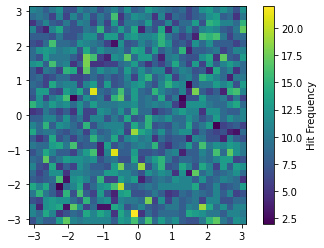

In [3]:
def createAndPlotRandomEvent():
  pi=3.14
  current_event_hits=np.random.uniform(-pi, pi, size=(2, 10000))
  counts, xedges, yedges = np.histogram2d(current_event_hits[0], current_event_hits[1], bins=32)
  print(counts)
  #plt.imshow(counts.reshape(32, 32), cmap=cm.Greys)
  plt.imshow(counts, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  cb = plt.colorbar()
  cb.set_label("Hit Frequency")
  return counts
counts=createAndPlotRandomEvent()
saveDataset('sampleRandomEventHistogram32x32.pkl',counts)

In [5]:

from google.colab import drive
drive.mount('/content/drive')
file_directory_path= '/content/drive/MyDrive/Projects/110_JetscapeMl/Hm.JetscapeMl.Data/'

#file_directory_path= 'G:\\My Drive\\Projects\\110_JetscapeMl\\Hm.JetscapeMl.Data\\'

#file_name='jetscape-ml-benchmark-dataset-2k-randomized.pkl'
file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-2000.pkl'
# file_name='jetscape-ml-benchmark-dataset-matter-vs-lbt-200k-shuffled-01.pkl'
(x_train, y_train), (x_test, y_test) =loadDataset(file_directory_path+file_name)
print(type(x_train), x_train.size, x_train.shape)
print(type(y_train), y_train.size, y_train.shape)
print(type(x_test), x_test.size, x_test.shape)
print(type(y_test), y_test.size, y_test.shape)
print(y_train[1500], y_test[99])

Mounted at /content/drive
<class 'numpy.ndarray'> 1638400 (1600, 32, 32)
<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 409600 (400, 32, 32)
<class 'numpy.ndarray'> 400 (400,)
MLBT MVAC


## 2. Use Matplotlib to visualize one record.  
I set the colormap to Grey and ColorMap. There are a bunch of other colormap choices if you like bright visualizations. Try magma or any of the other  choice in the [docs](https://matplotlib.org/tutorials/colors/colormaps.html).

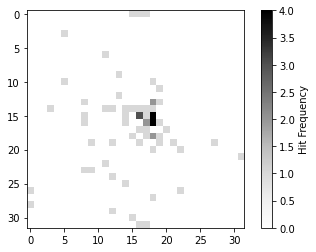

In [8]:
def plotEvent(image_frame_size,event_matrix):
  plt.imshow(event_matrix.reshape(image_frame_size, image_frame_size), cmap=cm.Greys)
  cb = plt.colorbar()
  cb.set_label("Hit Frequency")

image_frame_size=32
plotEvent(image_frame_size,x_train[55])

## 3. Plot a bunch of records to see sample data  
Basically, use the same Matplotlib commands above in a for loop to show 18 records from the train set in a subplot figure. We also make the figsize a bit bigger and remove the tick marks for readability.
** TODO: try to make the subplot like the below image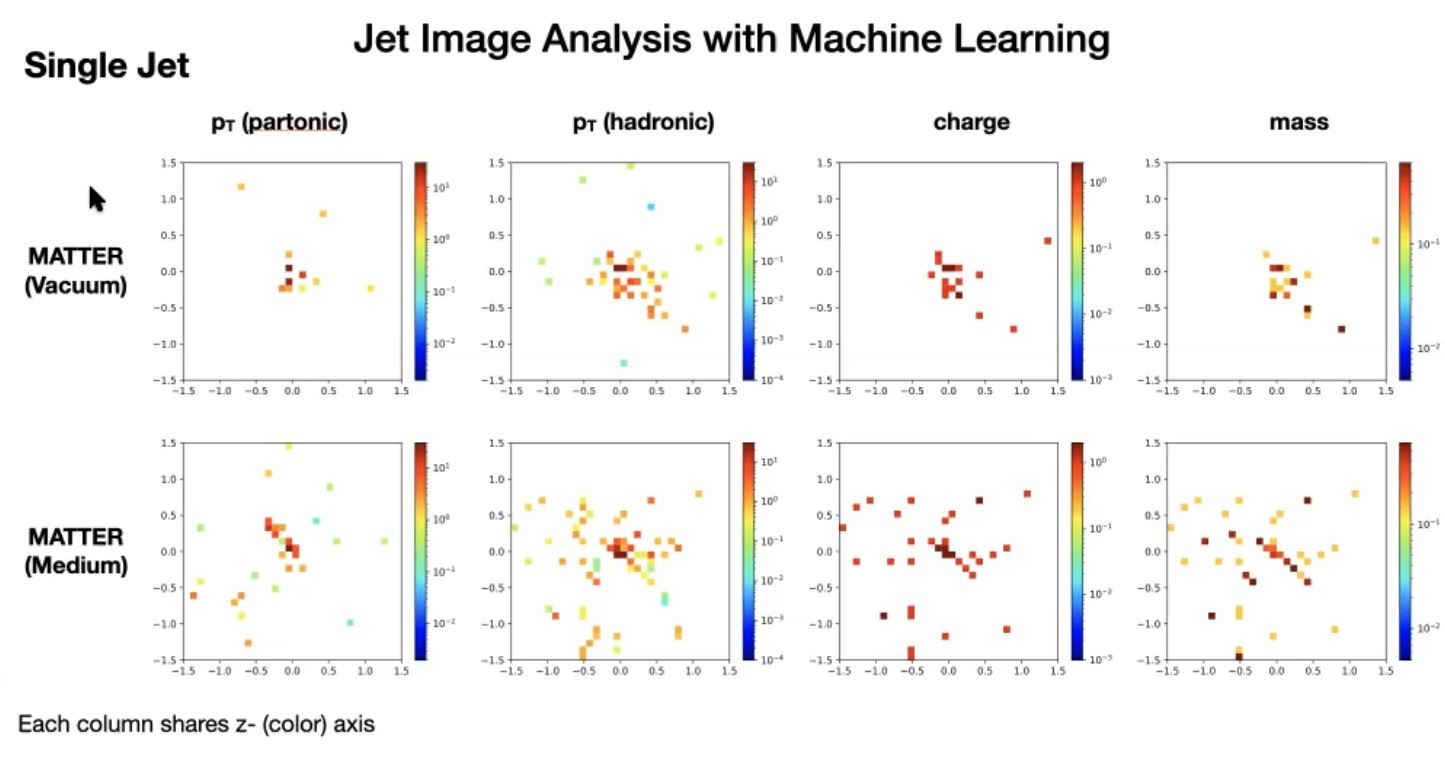



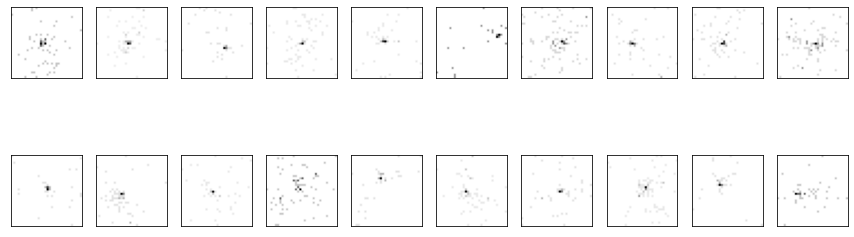

In [11]:
def plot20SampleEvents(events_matrix_items):
  # images = x_train[0:18]
  # fig, axes = plt.subplots(3, 6, figsize=[9,5])
  images = events_matrix_items
  fig, axes = plt.subplots(2, 10, figsize=[15,5])

  for i, ax in enumerate(axes.flat):
      current_plot= ax.imshow(x_train[i].reshape(32, 32), cmap=cm.Greys)
      ax.set_xticks([])
      ax.set_yticks([])
        
  plt.show
events_matrix_items=[x_train[0:10],x_train[1500:10]]
plot20SampleEvents(events_matrix_items)

## 3.1 Plot a bunch of records to see sample data after shuffling
Basically, use the same Matplotlib commands above in a for loop to show 18 records from the train set in a subplot figure. We also make the figsize a bit bigger and remove the tick marks for readability.
** This Part is unneccesary, because the dataset is already loaded as shuffled or unshuffled in previous steps

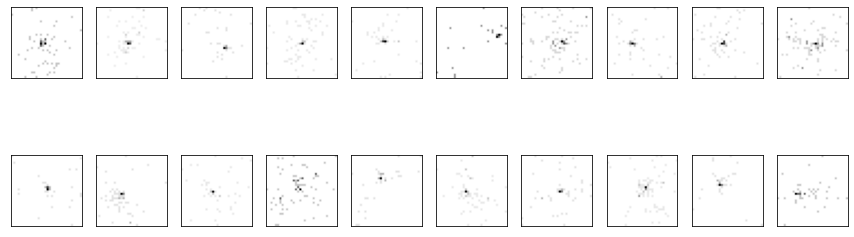

In [12]:
events_matrix_items=x_train[0:20]
plot20SampleEvents(events_matrix_items)

## 4. Show distribution of training data labels   
The training data is about evenly distributed across all nine digits. 

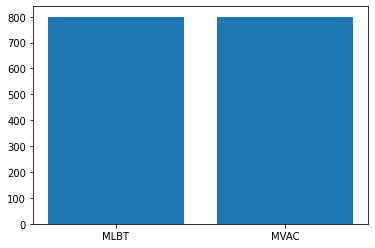

[800 800]
['MLBT' 'MVAC']
['MLBT' 'MVAC']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
def plotYTrainDatasetDistribution(y_train):
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)


  counts = np.bincount(positions)
  plt.bar(unique_class_labels, counts)
  plt.show()
  print(counts)
  print(unique_class_labels)
  unique_class_labels,positions = np.unique(y_train,return_inverse=True)
  print(unique_class_labels)
  print(positions[1:20])
plotYTrainDatasetDistribution(y_train)

## 4.1 Show distribution of **shuffled** training data labels   
The training data is about evenly distributed across all classes. 

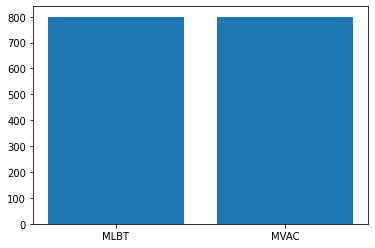

[800 800]
['MLBT' 'MVAC']
['MLBT' 'MVAC']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [14]:
plotYTrainDatasetDistribution(y_train)

# Changing classification labels from Literal to Numeric

---



In [20]:
def convertDatasetYFromLiteralToNumeric(y_dataset):
  y_train=y_dataset[0]
  y_test=y_dataset[1]
  y_train_unique_class_labels,y_train_positions = np.unique(y_train,return_inverse=True)
  y_test_unique_class_labels,y_test_positions = np.unique(y_test,return_inverse=True)

  print(type(y_train), y_train.size, y_train.shape)
  print(type(y_test), y_test.size, y_test.shape)
  print(type(y_train[0]))
  print(type(y_test[0]))

  print(y_train_unique_class_labels)
  print(y_test_unique_class_labels)
  y_train=y_train_positions
  y_test=y_test_positions
  print(type(y_train), y_train.size, y_train.shape)
  print(type(y_test), y_test.size, y_test.shape)

  print(type(y_train[0]))
  print(type(y_test[0]))
  return ((y_train,y_test))
y_train,y_test =convertDatasetYFromLiteralToNumeric((y_train,y_test))

<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 400 (400,)
<class 'numpy.int64'>
<class 'numpy.int64'>
[0 1]
[0 1]
<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 400 (400,)
<class 'numpy.int64'>
<class 'numpy.int64'>


# Changing classification labels for Shuffled Dataset from Literal to Numeric
** This part is unnecssary, it is just kept to show that there is a difference between training shuffled and unshuffled


In [17]:
y_train,y_test =convertDatasetYFromLiteralToNumeric((y_train,y_test))

<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 400 (400,)
<class 'numpy.int64'>
<class 'numpy.int64'>
[0 1]
[0 1]
<class 'numpy.ndarray'> 1600 (1600,)
<class 'numpy.ndarray'> 400 (400,)
<class 'numpy.int64'>
<class 'numpy.int64'>


## Normalizing the dataset 

In [24]:
def calculateDatasetXMaxValue(x_dataset):
  x_train=x_dataset[0]
  x_test=x_dataset[1]
  max_x=np.amax([np.amax(x_train), np.amax(x_test)])
  return max_x

def normalizeDatasetXValueRangeBetween0And1(x_dataset,max_x):
  x_train=x_dataset[0]
  x_test=x_dataset[1]

  # Normalize the data to a 0.0 to 1.0 scale for faster processing
  x_train, x_test = x_train / max_x, x_test / max_x
  return (x_train, x_test)

x_dataset=(x_train,x_test)
max_x=calculateDatasetXMaxValue(x_dataset)
x_train,x_test=normalizeDatasetXValueRangeBetween0And1(x_dataset,max_x)

image_frame_size=32
print(max_x)


1.0


##Defining Validation Dataset from Train Dataset

In [33]:
# Reserve 300 samples for validation
x_val = x_train[-300:]
y_val = y_train[-300:]
x_train = x_train[:-300]
y_train = y_train[:-300]
print(type(y_train), y_train.size, y_train.shape)
print(type(x_train), x_train.size, x_train.shape)

print(type(y_val), y_val.size, y_val.shape)
print(type(x_val), x_val.size, x_val.shape)

print(type(y_test), y_test.size, y_test.shape)
print(type(x_test), x_test.size, x_test.shape)

<class 'numpy.ndarray'> 1300 (1300,)
<class 'numpy.ndarray'> 1331200 (1300, 32, 32)
<class 'numpy.ndarray'> 300 (300,)
<class 'numpy.ndarray'> 307200 (300, 32, 32)
<class 'numpy.ndarray'> 400 (400,)
<class 'numpy.ndarray'> 409600 (400, 32, 32)


## 5.1 Apply Keras/TensorFlow neural network  
Use tensorflow to train the model with 1600/180K training records, compile the model, and classify 400/20K test records and calcualte the accuracy accuracy.  
**Create the model**  
Build the keras model by stacking layers into the network. Our model here has four layers:
- Flatten reshapes the data into a 1-dimensional array
- [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) tells the model to use output arrays of shape (*, 512) and sets rectified linear [activation function](https://keras.io/activations/). 
- [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) applies dropout to the input to help avoid overfitting.
- The next Dense line condenses the ouput into probabilities for each of the 2 Energy Loss Classes.

**Compile the model**   
- [Adam](https://keras.io/optimizers/) is an optimization algorithm that uses stochastic gradient descent to update network weights.
- Sparse categorical crossentropy is a [loss function](https://keras.io/losses/) that is required to compile the model. The loss function measures how accurate the model is during training. We want to minimize this function to steer the model in the right direction.
- A metric is a function that is used to judge the performance of your model. We're using accuracy of our predictions as compared to y_test as our metric.  
Lastly, we fit our training data into the model, with several training repetitions (epochs), then evaluate our test data. 

Our final result is about ?% accuracy in classifying 400/20K events in the test set. You can try tweaking this model with different settings to get a better score. An easy tweak is increasing the epochs, which improves accuracy at the expense of time. Follow the links to the Keras layer docs above and try different options for Dense output, activation functions, optimization algorithms and loss functions.

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `x_train` and `y_train` arrays, which are the images and labels.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `x_test` array. We verify that the predictions match the labels from the `y_test` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:
*Setting number of Epochs to 1000*

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 2)                 2050      
                                                                 
 dropout_5 (Dropout)         (None, 2)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 3         
                                                                 
Total params: 2,053
Trainable params: 2,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
21/21 [==============================] - 1s 26ms/step - loss: 0.6896 - acc: 0.5938 - val_loss: 0.7204 - val_acc: 0.0000e+00
Epoch 2/10
21/21 [==========================

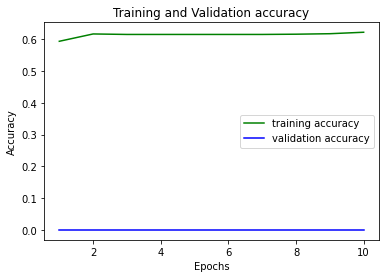

Elapsed 3.155 seconds.


In [40]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


# def buildAndCompileNNModel(image_frame_size,max_x):
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(image_frame_size, image_frame_size)),
#   tf.keras.layers.Dense(max_x+1, activation=tf.nn.relu),
#   tf.keras.layers.Dropout(0.25),
#   tf.keras.layers.Dense(2, activation=tf.nn.softmax)
# ])
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(image_frame_size, image_frame_size)),
  tf.keras.layers.Dense(max_x+1, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
print(model.summary())

model.compile(optimizer=tf.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['acc'])
  # return model

  # model=buildAndCompileNNModel(image_frame_size,max_x)

start_time =time.perf_counter()
# y_train_unique_class_labels,y_train_positions = np.unique(y_train,return_inverse=True)
# y_train_positions
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# , verbose=0, validation_split = 0.1,
#                     callbacks=[early_stop, PrintDot()]
# history =model.fit(x_train, y_train, epochs=1000)
# history =model.fit(x_train, y_train, epochs=10)

no_epoch=10
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=no_epoch,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val))

model.save('matter_vs_matterlbt_2k.h5')
acc_train = history.history['acc']
acc_val = history.history['val_acc']
print(acc_train)
print(acc_train)
epochs = range(1,no_epoch+1)
plt.plot(epochs,acc_train, 'g', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

elapsed_time=time.perf_counter() - start_time
print('Elapsed %.3f seconds.' % elapsed_time)

## 5.2 Apply Keras/TensorFlow CNN

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 128)       

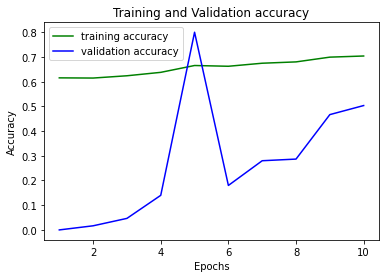

Elapsed 21.388 seconds.


In [41]:
# import tensorflow as tf


# from tensorflow import keras
# from keras_preprocessing import image
# from keras_preprocessing.image import ImageDataGenerator

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(image_frame_size,image_frame_size,1)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    # tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

model.summary()

model.compile(optimizer=tf.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['acc'])



print("Fit model on training data")
# fit(object, x = NULL, y = NULL, batch_size = NULL, epochs = 10,
#   verbose = getOption("keras.fit_verbose", default = 1),
#   callbacks = NULL, view_metrics = getOption("keras.view_metrics",
#   default = "auto"), validation_split = 0, validation_data = NULL,
#   shuffle = TRUE, class_weight = NULL, sample_weight = NULL,
#   initial_epoch = 0, steps_per_epoch = NULL, validation_steps = NULL,
#   ...)
# -> object : the model to train.      
# -> X : our training data. Can be Vector, array or matrix      
# -> Y : our training labels. Can be Vector, array or matrix       
# -> Batch_size : it can take any integer value or NULL and by default, it will
# be set to 32. It specifies no. of samples per gradient.      
# -> Epochs : an integer and number of epochs we want to train our model for.      
# -> Verbose : specifies verbosity mode(0 = silent, 1= progress bar, 2 = one
# line per epoch).      
# -> Shuffle : whether we want to shuffle our training data before each epoch.      
# -> steps_per_epoch : it specifies the total number of steps taken before
# one epoch has finished and started the next epoch. By default it values is set to NULL.

start_time =time.perf_counter()

no_epoch=10
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=no_epoch,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val))

model.save('matter_vs_matterlbt_2k.h5')
acc_train = history.history['acc']
acc_val = history.history['val_acc']
print(acc_train)
print(acc_train)
epochs = range(1,no_epoch+1)
plt.plot(epochs,acc_train, 'g', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

elapsed_time=time.perf_counter() - start_time
print('Elapsed %.3f seconds.' % elapsed_time)

In [ ]:
hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch
# hist['rmse']=np.sqrt( hist.loss)
hist['accuracy']=np.sqrt( hist.accuracy)

print(hist)
print("Mean Training Accuracy", np.mean(hist.accuracy))
# rmse_final = np.sqrt(float(hist['loss']))
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Mean Square Error')
    plt.ylabel('Loss(Blue)/Accuracy(Orange)')
    plt.plot(hist['epoch'], hist['loss'], label='loss')
    plt.plot(hist['epoch'], hist['accuracy'], label='accuracy')
    # plt.plot(hist['epoch'], hist['rmse'], label = 'RMSE')
    plt.legend()
    plt.ylim([0,1])

plot_history()

In [ ]:
hist = pd.DataFrame(history_shuffled.history)

hist['epoch'] = history.epoch
# hist['rmse']=np.sqrt( hist.loss)
hist['accuracy']=np.sqrt( hist.accuracy)

print(hist)
print("Mean Training Accuracy", np.mean(hist.accuracy))
# rmse_final = np.sqrt(float(hist['loss']))
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Mean Square Error')
    plt.ylabel('Loss(Blue)/Accuracy(Orange)')
    plt.plot(hist['epoch'], hist['loss'], label='loss')
    plt.plot(hist['epoch'], hist['accuracy'], label='accuracy')
    # plt.plot(hist['epoch'], hist['rmse'], label = 'RMSE')
    plt.legend()
    plt.ylim([0,1])

plot_history()

#Binary Classification Results


Classification                      | #epoch | Hadron \begin{pmatrix} p_{T} \end{pmatrix}
-------------------                 |--------|------------------
MATTER (in-medium) v.s. MATTER+LBT  |500| 95.88%
 

#Precision - Recall - F1Score

$precision= \frac{true \: positive}{true \: positive \: + \:false \: positive}$

$recal= \frac{true \: positive}{true \: positive \: + \: false \: negative}$

$f1-score= \frac{2}{precision^{-1} \: + \: recall^{-1}}$

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [ ]:
prediction=model.predict(x_test)
prediction=[ 1 if current_y_test>0.5 else 0 for current_y_test in prediction ]
#checking if prediction vector is binary
truth=y_test

              precision    recall  f1-score   support

           0       0.50      0.65      0.57     10000
           1       0.51      0.36      0.42     10000

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.50     20000
weighted avg       0.51      0.51      0.50     20000



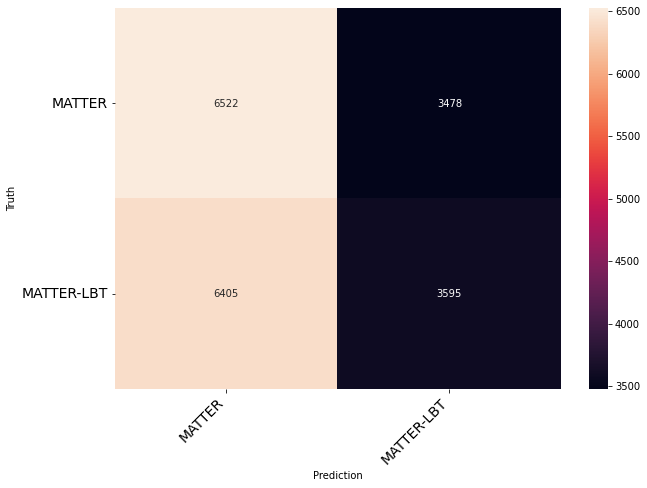

In [ ]:
cm = confusion_matrix(truth,prediction)
print_confusion_matrix(cm,["MATTER","MATTER-LBT"])
print(classification_report(truth, prediction))

F1 Score for MATTER

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [ ]:
from sklearn import metrics

# Predict
pred = model.predict(x_test)
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(mse))
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))


Final score (MSE): 0.3986714993310698
Root Mean Square Error on test set: 0.631


In [ ]:
from sklearn import metrics

# Predict
pred = model_shuffled.predict(x_test_shuffled)
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,y_test_shuffled)
print("Final score (MSE): {}".format(mse))
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))


Final score (MSE): 0.37391138926287576
Root Mean Square Error on test set: 0.611


### Evaluate accuracy

To predict new values, the Neural Network uses classifier.predict. I'm going to pass it the test values for x_test (which the Neural Network hasn't previously seen) and it will give me back a set of predictions. These predicitons will be probabilities, so I will clean them up by saying that if thye are greater than .5, I'll make them 1, else I'll make them 0.
Next, compare how the model performs on the test dataset:


In [ ]:
print(x_test.shape)
y_test_prediction=model.predict(x_test)

y_test_prediction = [ 1 if y_test>0.5 else 0 for y_test in y_test_prediction ]
print(y_test_prediction)
total = 0
correct = 0
wrong = 0
for i in y_test_prediction:
  total=total+1
  if(y_test[i] == y_test_prediction[i]):
    correct=correct+1
  else:
    wrong=wrong+1

print("Total " + str(total))
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print(correct/total)
print(wrong/total)

test_loss, test_acc = model.evaluate(x_test, y_test)

(400, 32, 32)
[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0

In [ ]:
print(x_test_shuffled.shape)
y_test_prediction=model.predict(x_test_shuffled)

y_test_prediction = [ 1 if y_test>0.5 else 0 for y_test in y_test_prediction ]
print(y_test_prediction)
total = 0
correct = 0
wrong = 0
for i in y_test_prediction:
  total=total+1
  if(y_test[i] == y_test_prediction[i]):
    correct=correct+1
  else:
    wrong=wrong+1

print("Total " + str(total))
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print(correct/total)
print(wrong/total)

test_loss, test_acc = model_shuffled.evaluate(x_test_shuffled, y_test_shuffled)

(400, 32, 32)
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0

Often times, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. In our case, the accuracy is better at 60.5. This is, in part, due to successful regularization accomplished with the Dropout layers.

### Make predictions

With the model trained, we can use it to make predictions about some events. Let's step outside the dataset for that and go with the beautiful high-resolution images generated by a real world expiremental dataset.

In [ ]:
import cv2
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# download the video if running in Colab
if not os.path.isfile(mnist_dream_path): 
    print('downloading the sample video...')
    vid_url = this_tutorial_url + '/' + mnist_dream_path
    
    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes() 
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)
def cap_read(frame):
    img= x_test[frame-1]
    if img is not None:
      ret=True
    else:
      ret=False
    return ret, img 
# cap = cv2.VideoCapture(mnist_dream_path) 
cap = x_test[100:300]
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    # ret, img = cap.read()
    ret, img = cap.read(frame)
    if not ret: break
               
    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 32:
        img = cv2.resize(img, (32, 32))
       
    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (32, 32))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)
    
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
cap.release()
if vw is not None:
    vw.release()

14.0